<a href="https://colab.research.google.com/github/Joygarden425/AI-Project/blob/main/CV_Pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

In [41]:
## 2) Hyperparameter
batch_size=16
learning_rate=0.0001
epoch=20

n_node = 1024
dropratio = 0.5

imgsize = 256

In [42]:
# Train data
img_dir = "/content/drive/MyDrive/CVdata/pattern/train"
train_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(imgsize * 2),
    transforms.RandomCrop(imgsize),
    transforms.RandomHorizontalFlip(),

    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size = batch_size,
                              shuffle = True, num_workers = 2)

180


In [43]:
# Val data
img_dir = "/content/drive/MyDrive/CVdata/pattern/val"

dev_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(size = imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))
print(train_data.__len__())

dev_batch = data.DataLoader(dev_data, batch_size = batch_size,
                              shuffle = False, num_workers = 2)

180


In [44]:
#test data
img_dir = "/content/drive/MyDrive/CVdata/pattern/test"

test_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(size = imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))
print(train_data.__len__())

test_batch = data.DataLoader(dev_data, batch_size = batch_size,
                              shuffle = False, num_workers = 2)

180


In [45]:
nclass = len(train_data.classes)
print ("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d"
%(train_data.__len__(),dev_data.__len__(),test_data.__len__()))



# of classes: 2
['check', 'stripe']
{'check': 0, 'stripe': 1}
180
Training: 180, Dev: 40, Test: 20


In [46]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['check', 'stripe']
['check', 'stripe']
['check', 'stripe']


In [47]:
vgg = models.vgg19(pretrained = True)

for name, module in vgg.named_children():
    print(name)

print(list(vgg.children())[0])
print(list(vgg.children())[-1])

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [48]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [49]:
base_dim = 64
fsize = imgsize//32

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        self.layer0=nn.Sequential(*list(vgg.children())[0])

        self.layer1=nn.Sequential(
            nn. Linear (8*base_dim *fsize * fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),

            nn. Linear (n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),

            nn. Linear (n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),

            nn.Linear(n_node,nclass)
        )
        for m in self.layer1.modules():

            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)

    def forward(self,x):
        out = self.layer0(x)
        out = out.view(out.size(0),-1)
        out = self.layer1(out)

        return out


In [50]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False

for params in model.layer1.parameters():
    params.required_grad = True

for name in model.children():
    print(name)


<ipython-input-49-09991304d4ca>:33: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight.data)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [51]:
loss_func = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

In [53]:
import cv_utils
total_time = 0
disp_step = 10

to_train = True


if (to_train==False):
    netname = '/content/drive/MyDrive/model/myvgg.pkl'
    model = torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f" % (n_node, dropratio))
    model.eval()
    train_corr = cv_utils.ComputeCorr(train_batch, model.cuda())
    dev_corr = cv_utils.ComputeCorr(dev_batch, model.cuda())
    test_corr = cv_utils.ComputeCorr(test_batch, model.cuda())
    print("Correct of train: %.2f, val: %.2f, test: %.2f"
          % (train_corr, dev_corr,test_corr))
    model.train()

    netname = '/content/drive/MyDrive/model/myvgg'

    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []

    x_epoch.append(0)
    y_train_err.append(100.0 - train_corr)
    y_dev_err.append(100.0 - dev_corr)
    y_test_err.append(100.0 - test_corr)

    for i in range(epoch):
        start_time = time.time()
        print("%d.." % i)
        for img, label in train_batch:

            img = img.cuda()
            label = label.cuda()

            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()

        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i % disp_step == 0) or (i == epoch - 1):
            torch.save(model, netname + '_%d.pkl' % i)
            print("# [%d/%d] loss: %.3f" % (i, epoch, (loss.cpu()).data.numpy()))

            model.eval()
            train_corr = cv_utils.ComputeCorr(train_batch, model.cuda())
            dev_corr = cv_utils.ComputeCorr(dev_batch, model.cuda())
            test_corr = cv_utils.ComputeCorr(test_batch, model.cuda())
            print("Correct of train: %.2f, val: %.2f, test: %.2f"
                  % (train_corr, dev_corr,test_corr))
            model.train()
            print("time: %.2f sec.." % total_time)

            x_epoch.append(i + 1)
            y_train_err.append(100.0 - train_corr)
            y_dev_err.append(100.0 - dev_corr)
            y_test_err.append(100.0 - test_corr)

print("Total time: %.2f sec.." % total_time)


3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 94.44, val: 75.00, test: 75.00
0..
# [0/20] loss: 0.067
Correct of train: 96.67, val: 85.00, test: 85.00
time: 13.36 sec..
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..
# [10/20] loss: 0.005
Correct of train: 98.33, val: 85.00, test: 85.00
time: 146.96 sec..
11..
12..
13..
14..
15..
16..
17..
18..
19..
# [19/20] loss: 1.486
Correct of train: 100.00, val: 82.50, test: 82.50
time: 263.59 sec..
Total time: 263.59 sec..


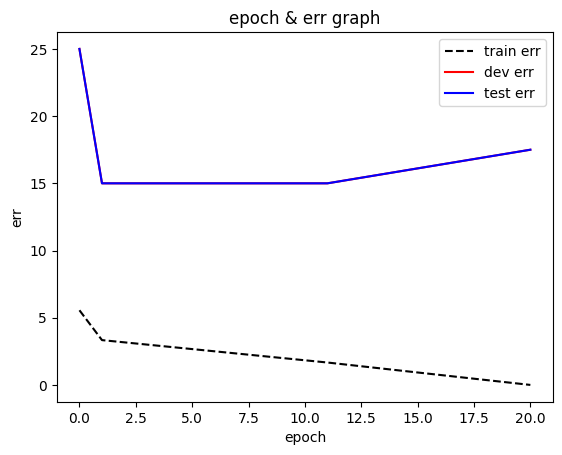

In [54]:
import matplotlib.pyplot as plt

# epoch-err curve
if to_train:
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')

    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc='upper right')
    plt.show()


Normalized confusion matrix


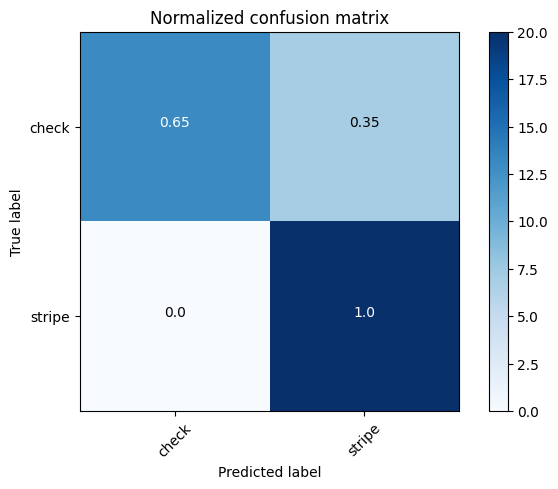

Confusion matrix, without normalization


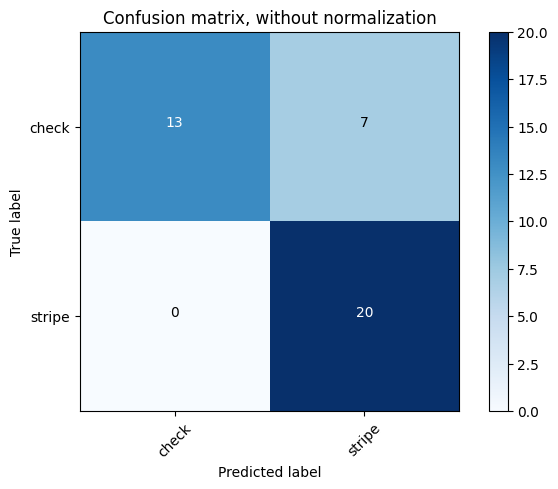

	 acc  |	 pre  |	 rec  |	 f1
 check: 0.82 |	 1.00 |	 0.65 |	 0.79
 stripe: 0.82 |	 0.74 |	 1.00 |	 0.85
*accuracy: 0.82, precision: 0.87, recall: 0.82, *f1 score: 0.82
[AP]
check: 0.94
stripe: 0.92

[mAP] 0.928
[miAP] 0.912


(array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0.99573302, 0.99959731, 0.99960566, 0.9999488 , 0.99934363,
        0.99986732, 0.99826843, 0.99882752, 0.99912506, 0.99765503,
        0.98618728, 0.99833351, 0.99925691, 0.83031076, 0.99628919,
        0.98697662, 0.53560573, 0.53191882, 0.94104052, 0.99938047,
        0.9998188 , 0.99550098, 0.99873465, 0.9993608 , 0.99835843,
        0.9993189 , 0.99954361, 0.99833906, 0.99690598, 0.99954194,
        0.9966138 , 0.99395293, 0.99992239, 0.99948871, 0.99983656,
        0.99980217, 0.99684048, 0.99535233, 0.99944067, 0.96924394]))

In [55]:
dev_batch_cuda = [(img.cuda(), label.cuda()) for img, label in dev_batch]
model.cuda()

model.eval()
cv_utils.EvaluateClassifier(dev_batch_cuda, model, dev_data.classes, batch_size)


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Category: check
 True predicted images/total check category: 13 / 20
Predicted probability:
[0.995733   0.00426697]


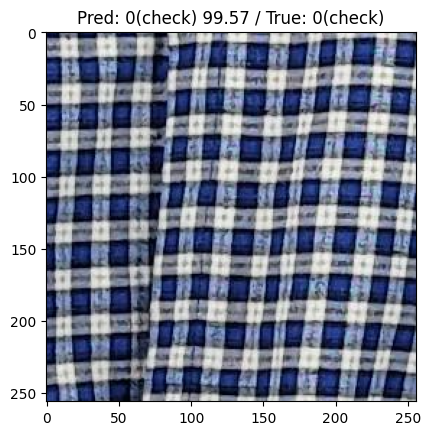

Predicted probability:
[9.995973e-01 4.027116e-04]


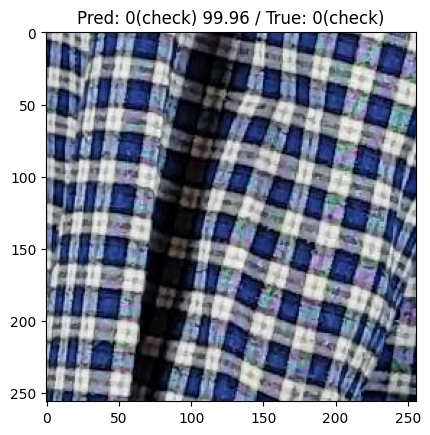

 False predicted images/total check category: 7 / 20
Predicted probability:
[0.00173159 0.9982684 ]


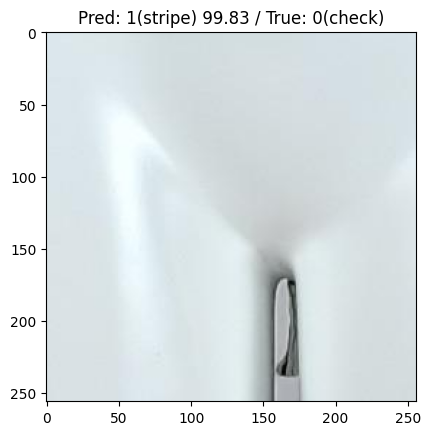

Predicted probability:
[0.00117248 0.9988275 ]


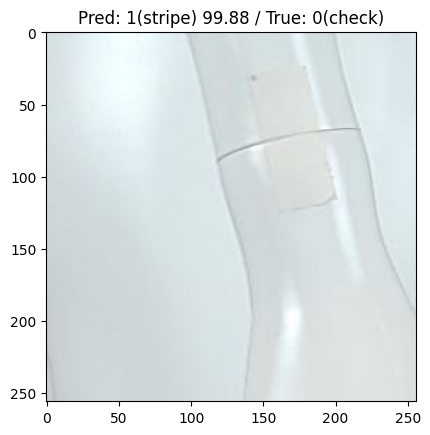

Category: stripe
 True predicted images/total stripe category: 20 / 20
Predicted probability:
[1.8117948e-04 9.9981880e-01]


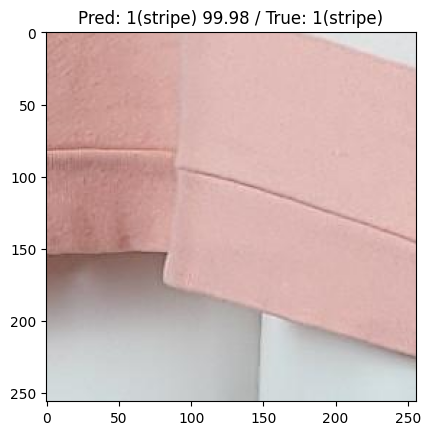

Predicted probability:
[0.00449901 0.995501  ]


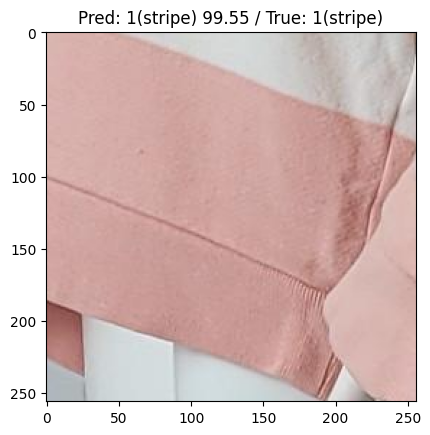

 False predicted images/total stripe category: 0 / 20


In [56]:
dev_batch_cuda = [(img.cuda(), label.cuda()) for img, label in dev_batch]
model.cuda()

cv_utils.VisTFPred(dev_batch_cuda, model, test_data.classes, batch_size, i_n=2)
